In [1]:
!pip install contractions
try:
    import spacy
    import cupy as cp
    print("Packages already available")
except:
    print("Installing minimal packages...")
    !pip install spacy -q
    !pip install cupy-cuda11x -q  # Much faster than spacy[cuda112]
!python -m spacy download en_core_web_sm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 9.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 7.4 MB/s eta 0:00:00
Packages already available
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 86.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [1]:
import pandas as pd
import numpy as np
import re
import cupy as cp
import contractions
import torch
import wordcloud
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
import glob

ModuleNotFoundError: No module named 'contractions'

In [3]:
if spacy.prefer_gpu():
    print("Using GPU")
else:
    print("Using CPU")

# Load spaCy model
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner']) 

Using GPU


In [5]:
data = pd.read_csv('/kaggle/input/amazon-product-reviews/Reviews.csv')

In [6]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [7]:
target = data['Score']
data.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary'], axis=1, inplace=True)

In [8]:
lengths = [len(x) for x in data.Text]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


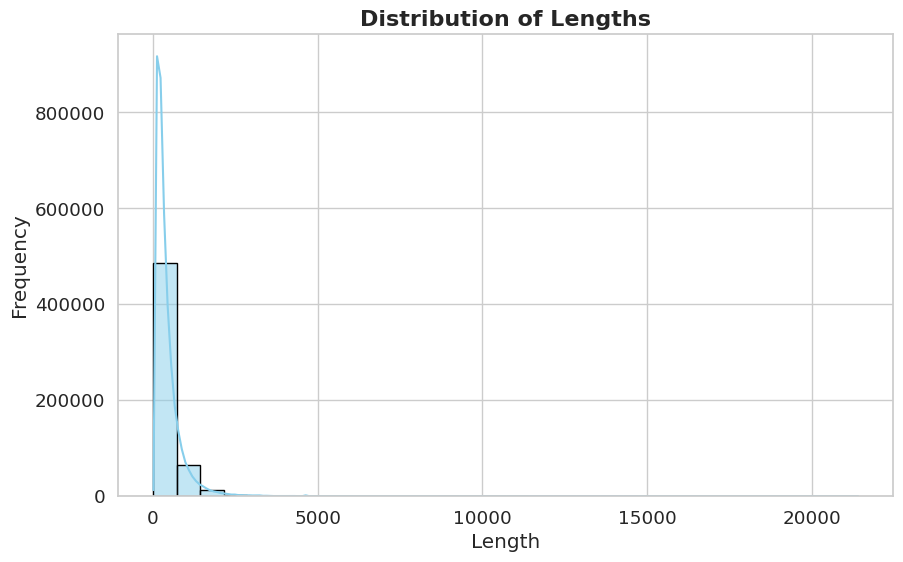

In [9]:
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

plt.figure(figsize=(10,6))
sns.histplot(lengths, kde=True, bins=30, color="skyblue", edgecolor="black")

plt.title("Distribution of Lengths", fontsize=16, fontweight="bold")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show();

In [10]:
pd.Series(lengths).describe()

count    568454.000000
mean        436.222083
std         445.339741
min          12.000000
25%         179.000000
50%         302.000000
75%         527.000000
max       21409.000000
dtype: float64

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


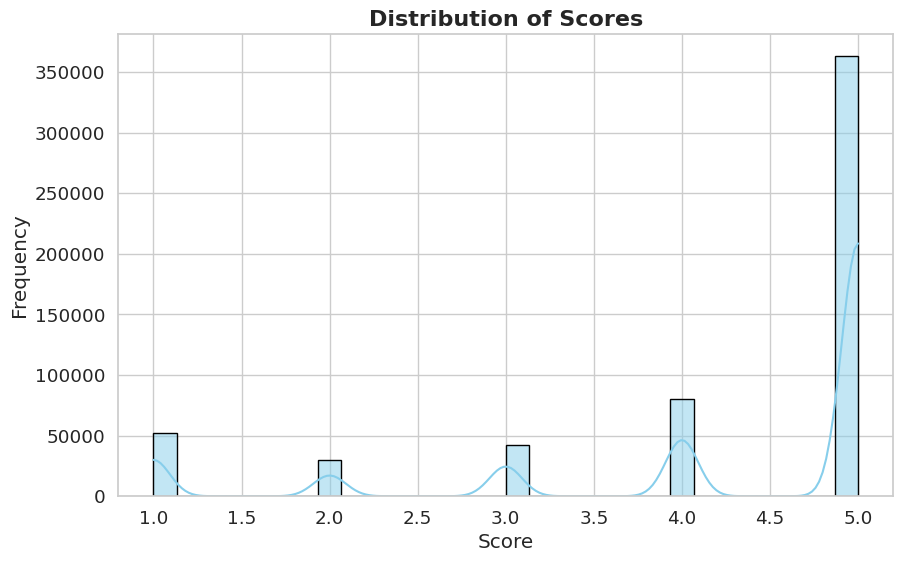

In [11]:
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

plt.figure(figsize=(10,6))
sns.histplot(target, kde=True, bins=30, color="skyblue", edgecolor="black")

plt.title("Distribution of Scores", fontsize=16, fontweight="bold")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

<div style="border-radius: 10px; border: #ffac00 solid; padding: 15px; background-color: #ffffff00; font-size: 150%; text-align: left;">  
    <b>💡 Info:</b> <b>data lengths distribution</b> is highly <b>right skewed</b>.<br>
    <b>💡 Info:</b> <b>target scores distribution</b> is highly <b>Imbalanced</b>.
</div>

In [12]:
data.shape

(568454, 2)

In [13]:
# training_data = np.array(data)
data.columns

Index(['Score', 'Text'], dtype='object')

In [14]:
data.duplicated().sum()

174779

In [15]:
data.drop_duplicates(inplace=True)

In [16]:
data.shape

(393675, 2)

In [17]:
def split_scores(data):
    unique, counts = np.unique(np.array(data['Score']), return_counts=True)
    minimum = counts.min() // 10
    
    df = data.copy().iloc[0:0]
    for val in unique:
        proportion = data[data['Score'] == val]
        proportion = proportion[:minimum]
        data = data[~data['Text'].isin(proportion['Text'])] 
        df = pd.concat([df, proportion], ignore_index=True)
    
    return data, df

In [18]:
training_data, val_data = split_scores(data.copy())

In [19]:
training_data.shape, val_data.shape

((383269, 2), (10400, 2))

In [20]:
nlp = spacy.load('en_core_web_sm')

In [21]:
def cleaning(dataset):
    """ unifying the container type
        and cleaning the text reviews
    """
    #Unifying the container type to Series
    #This enables flexibility as function can handle different container types
    if not isinstance(dataset, pd.Series):
        series = pd.Series(dataset)
    else:
        series = dataset.copy()

    #Lowercase and remove unnecessary characters from texts
    series = series.str.lower()
    series = series.str.replace('<[^>]+>', '', regex=True)
    series = series.str.replace(r'[^\w\s]', '', regex=True)
    series = series.str.replace(r'\s{2,}', '', regex=True)

    #Expaning contractions
    series = series.apply(contractions.fix)

    # Process with appropriate backend
    if spacy.prefer_gpu():
        print("Using GPU acceleration")
        doc = nlp.pipe(series, batch_size=4096, n_process=1) # Larger batches for GPU
    else:
        print("Using CPU")
        doc = nlp.pipe(series, batch_size=64, n_process=-1)
    # removing stop words and stemming
    cleaned_text = []
    
    for texts in spacy.util.minibatch(doc, size=2048):
        for text in texts:
            tokens = [token.lemma_ for token in text if not token.is_stop]
            cleaned_text.append(" ".join(tokens))

        torch.cuda.empty_cache()

    del series, doc
    gc.collect()
    
    return cleaned_text

In [22]:
cleaned_data = 'data'
os.makedirs(cleaned_data, exist_ok=True)
cleaned_data_directory = 'data/cleaned_data_reviews'
os.makedirs(cleaned_data_directory, exist_ok=True)
cleaned_val_directory = 'data/cleaned_val_reviews'
os.makedirs(cleaned_val_directory, exist_ok=True)

In [33]:
def cleaning_batches(dataset, batch_size, directory_path):
    data = dataset.copy()
    batch_size = batch_size
    
    for batch_start in range(0, len(data), batch_size):
        batch_end = min(batch_start + batch_size, len(data))
        outfile = os.path.join(directory_path, f"cleaned_data_review_{batch_start//batch_size + 1}.csv")

        if os.path.exists(outfile):
            print(f"batch {batch_start//batch_size + 1} is already processed\n")
            continue
                
        cleaned_batch = cleaning(data['Text'][batch_start:batch_end])
        print(f"batch {batch_start//batch_size + 1} processing completed\n")
    
        pd.DataFrame({'cleaned':cleaned_batch}).to_csv(outfile, index=False)
    
        del cleaned_batch
        gc.collect()

    
    files = sorted(glob.glob(directory_path+'/'+'cleaned_data_review_*.csv'))
    cleaned_reviews = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
            
    return cleaned_reviews

In [34]:
cleaned_training = cleaning_batches(training_data, 2**15, cleaned_data_directory)

Using GPU acceleration
batch 1 processing completed

Using GPU acceleration
batch 2 processing completed

Using GPU acceleration
batch 3 processing completed

Using GPU acceleration
batch 4 processing completed

Using GPU acceleration
batch 5 processing completed

Using GPU acceleration
batch 6 processing completed

Using GPU acceleration
batch 7 processing completed

Using GPU acceleration
batch 8 processing completed

Using GPU acceleration
batch 9 processing completed

Using GPU acceleration
batch 10 processing completed

Using GPU acceleration
batch 11 processing completed

Using GPU acceleration
batch 12 processing completed



In [35]:
cleaned_validation = cleaning_batches(val_data, 2000, cleaned_val_directory)

Using GPU acceleration
batch 1 processing completed

Using GPU acceleration
batch 2 processing completed

Using GPU acceleration
batch 3 processing completed

Using GPU acceleration
batch 4 processing completed

Using GPU acceleration
batch 5 processing completed

Using GPU acceleration
batch 6 processing completed



In [76]:
cleaned_training['score'] = pd.Series(training_data['Score'].values)
cleaned_validation['score'] = pd.Series(val_data['Score'].values)

In [89]:
cleaned_training.to_csv('data/cleaned_data_reviews/cleaned_training_reviews.csv', index=False)
cleaned_validation.to_csv('data/cleaned_val_reviews/cleaned_validating_reviews.csv', index=False)

# Phase Two
## tokenizing and embedding